In [305]:
#####################
#  1-D simulation of mechanochemical model in polar coordinates #
#                           Yuan He                             #
#                          15/04/2024                           #
#####################  

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from sympy import *
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d

##----------Initial setting----------##
# Initialize grid
X = 1        # Initial Length of the monolayer
X0 =0.1     # Initial inner radius of wound gap
T = 15       # Total simulation time
Nx = 500    # Number of spatial grid points
Nt = 1000    # Number of time steps
dx = X / Nx  # Spatial step size
dt = T / Nt  # Time step size
x = np.linspace(0, X, Nx + 1) # Spatial grid
t = np.linspace(0, T, Nt + 1) # Temporal grid

# Initialze variables
v = np.zeros(Nx + 1)
E = np.zeros(Nx + 1)
rho = np.ones(Nx + 1)
rho_0 = np.ones(Nx + 1)
rho_new = np.copy(rho)
rho_0_new = np.copy(rho)
E_new = np.copy(rho)
rho_flux = np.zeros(Nx + 1)
v_real = np.zeros(Nx+1)
rho_real = np.zeros(Nx+1)
L_values = np.ones(Nt + 1)
X0_values = np.ones(Nt + 1)
X0_values[0] = X0
RS = X0_values[0]
RE = X0_values[0]+1

# Parameters
chi = 0.2
alpha =6
beta = 4
sigma = 5
tau = 0.1
eta = 0.1
g = 1
k = 0

# Stored variables
dLvalues = []
E0_values = [] 
kymo_E = []
kymo_r = []
kymo_p = []
kymo_v = []
kymo_rho=[]

# Initialize Length at t=0
L_values[0] = 20

# Scaled variables
rho = rho*L_values[0]
rho_0 = rho_0*L_values[0]
E = E* L_values[0]

##----------Finish initial setting----------##

In [200]:
print(X0_values[0])

0.4


0.0
0
20.0


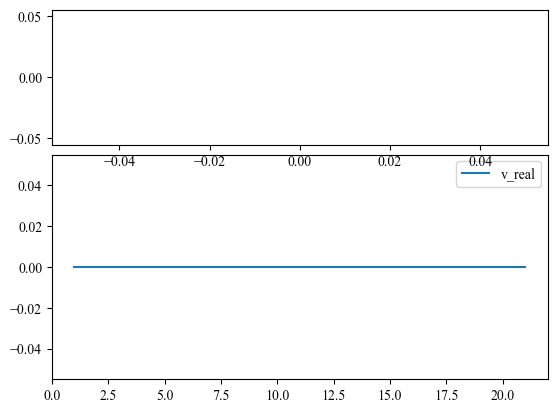

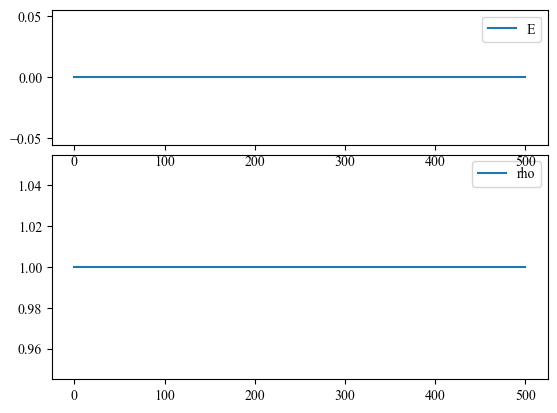

0.25
-0.285728382969680
20.07313230775874


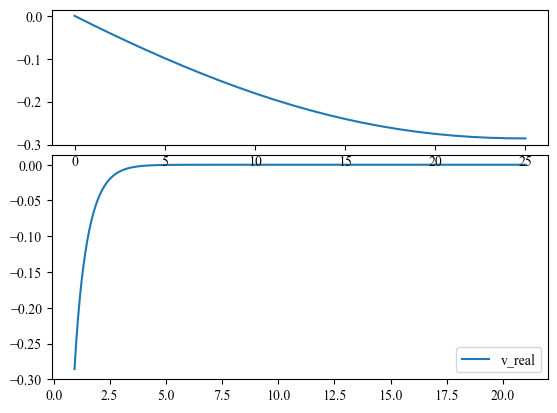

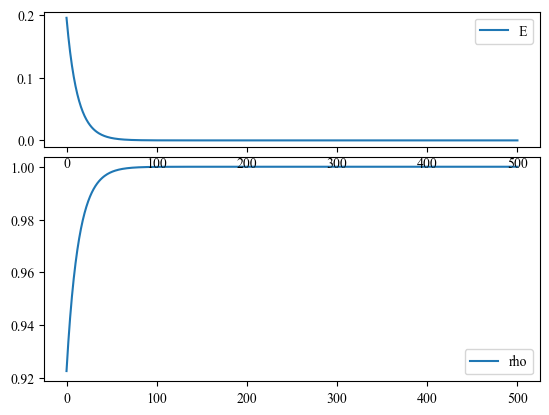

0.5
-0.190785705697686
20.162663146594227


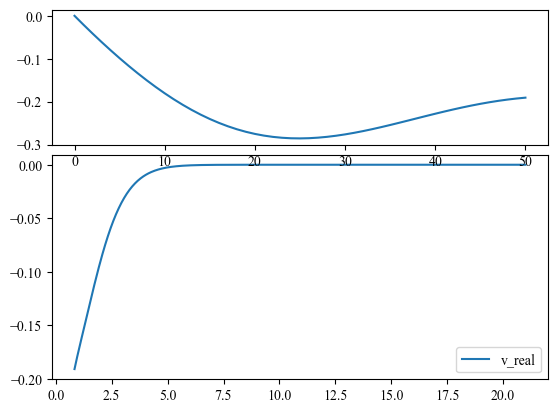

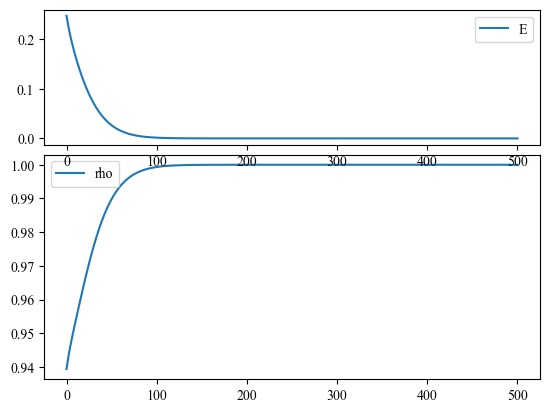

0.75
-0.243510670590731
20.24069054421222


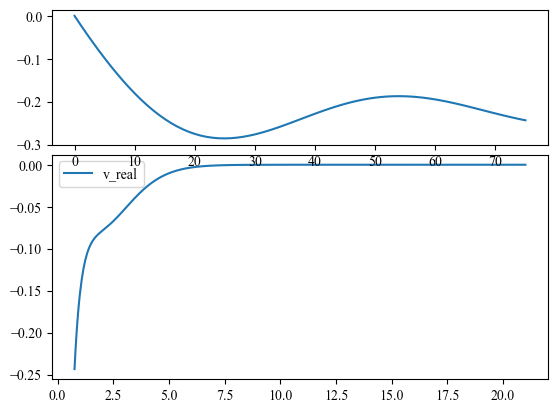

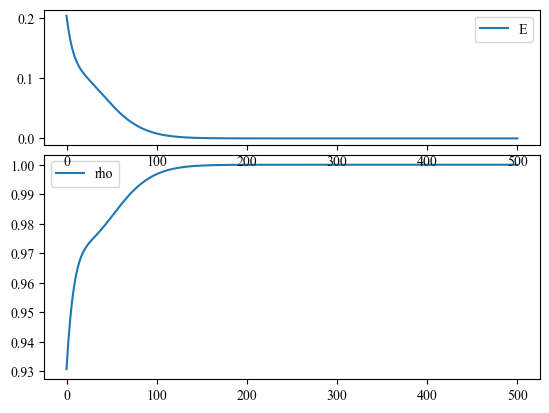

1.0
-0.227551729140779
20.333692488194178


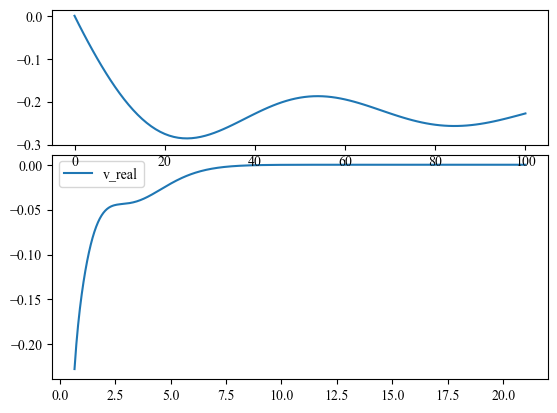

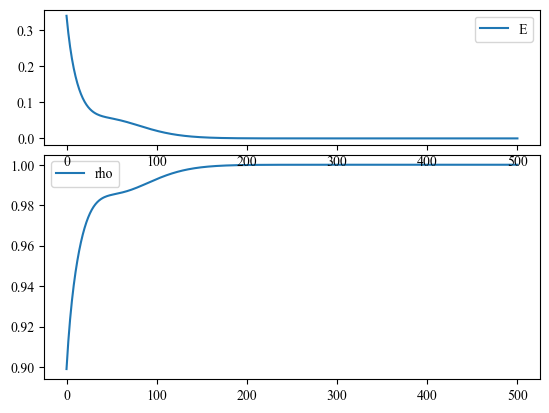

1.25
-0.199723480274057
20.410272202190917


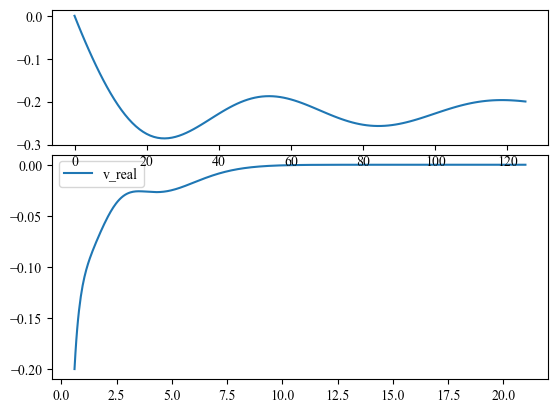

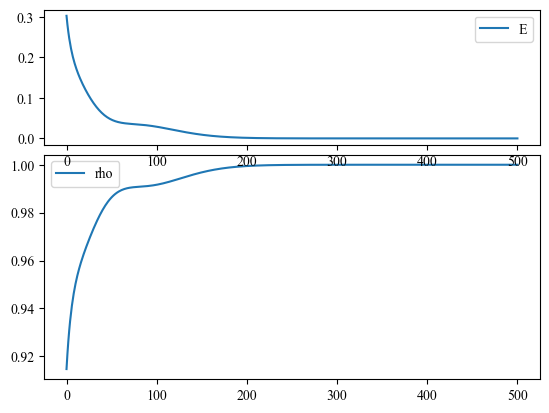

1.5
-0.207600783116744
20.488681776964114


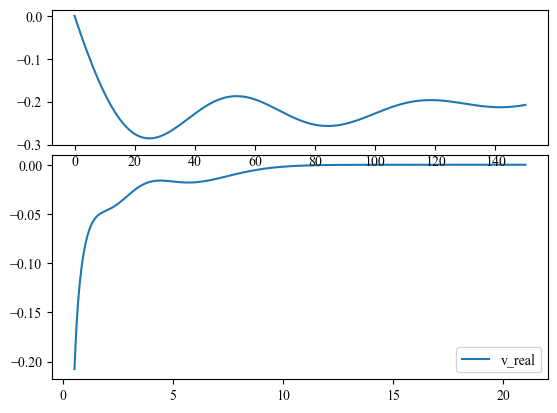

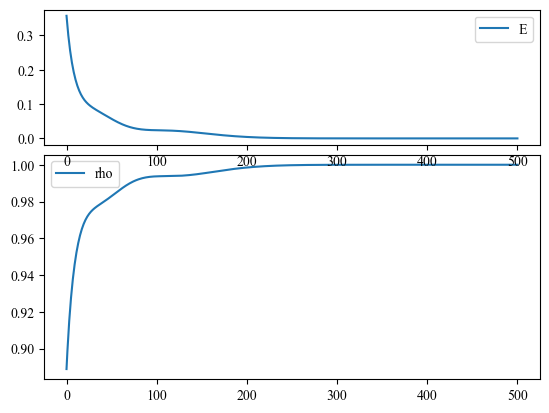

1.75
-0.161608692717835
20.55743050784276


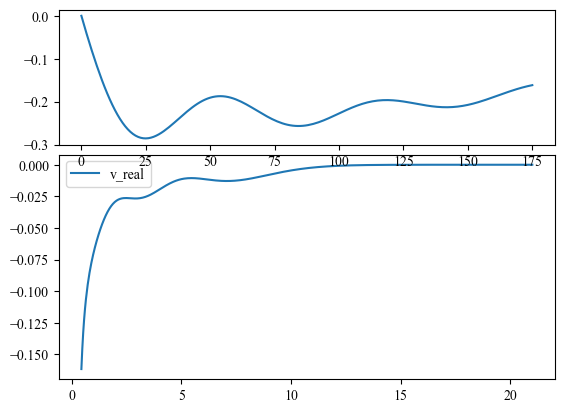

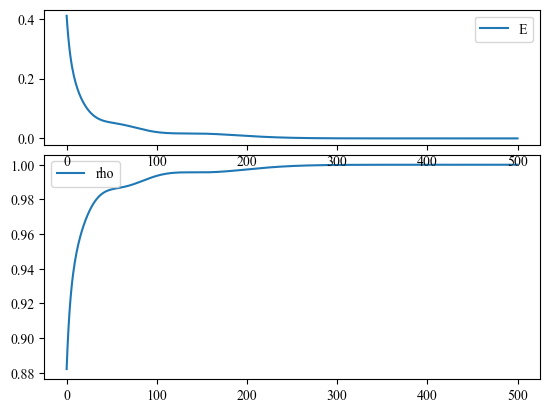

KeyboardInterrupt: 

In [306]:
for n in range(Nt):
    
    ##----------Calculate E and rho_0 based on ODEs----------##
    for i in range(0, Nx+1):
        
        # Calculate ODE
        rho_0_new[i] = rho_0[i]+(-rho_0[i]+L_values[0]+alpha*E[i])*dt
        E_new[i] = E[i] + (-E[i]-0*E[i]**3/L_values[0]**2-beta*(rho[i]-L_values[0]))/tau*dt
        
    rho_0 = rho_0_new
    E = E_new
    ##----------Finish calculating E and rho_0----------##
    
    ##----------Calculate S using FVM method----------##
    # Initialze grids
    r_original =np.linspace(RS, RE, Nx+1)

    # Create interpolation function
    rho_interp = interp1d(r_original, rho, kind='linear', fill_value="extrapolate")
    rho_0_interp = interp1d(r_original, rho_0, kind='linear', fill_value="extrapolate")

    # Define equations
    def odes(r, y):
        s, u = y
        rho_val = rho_interp(r)
        rho_0_val = rho_0_interp(r)
        return [u,-u/r + s/(r**2)+ ((r*L_values[0])**2+chi)/(r**2*chi)*(s +(rho_val-rho_0_val)/L_values[0]) - 2*chi/(r*((r*L_values[0])**2+chi)) *(u+s/r)]

    # Define boundary conditions
    def bc(ya, yb):
        return [ya[0]-1*sigma*(1 - np.exp(- 1*n/400))-0*1/(RS*L_values[0])*(1 - np.exp(- 1*n/400)), yb[1] + yb[0] / RE]
        # return [ ya[1] + ya[0] / (RS), yb[0]] for zero velocity at r=0

    # Initialize grid and estimate solution
    r_guess = np.linspace(RS, RE, Nx+1)
    y_guess = np.zeros((2, r_guess.size))
  
    # Use BVP method
    sol = solve_bvp(odes, bc, r_guess, y_guess)
    s = sol.sol(r_guess)[0]
    ##----------Finish calculating S----------##
    
    ##----------Calculate V ----------##

    # Calculate dL and L
    dL = Symbol('dL')
    solution = solve(((L_values[0]*RS)**2)/((L_values[0]*RS)**2+chi)*((s[1] -s[0])/(L_values[0]*dx)+s[1]/(L_values[0]*RS))-dL,dL)
    dL_value = dL.subs({dL: solution[0]})
    #dL_value = dL.subs({dL: 0}) for zero velocity at r=0
    dLvalues.append(dL_value)
    L_values[n+1] = L_values[n]-dL_value*dt
    
    # Calculate V
    v_real[0] = v[0] + dL_value
    v_real[Nx] = 0
    for i in range(1,Nx):
        v[i] = (RS+i*dx)**2*L_values[0]/((L_values[0]*(RS+i*dx))**2+chi)*((s[i+1] -s[i])/dx+s[i+1]/(RS+i*dx))- dL_value/X*(X-i*dx)
        v_real[i] = v[i] + dL_value/X*(X-i*dx)
    
    ##----------Finish calculating V ----------##
    
    ##----------Calculate rho using Fvm----------##

    rho_flux[0] = rho[0] * v_real[0]/L_values[0]
    rho_flux[1] = rho[1] * v_real[1]/L_values[0]
    rho_real[0] = rho[0]/L_values[0] - ((rho_flux[1] - rho_flux[0])/(dx*L_values[0])+rho_flux[0]/(L_values[0]*RS))*dt
    
    # Update rho using upwind finite volume method  
    for i in range(1, Nx):
        
        rho_flux[i] = rho[i] * v_real[i]/L_values[0]
        rho_flux[i+1] = rho[i+1] * v_real[i+1]/L_values[0]
        rho_flux[i-1] = rho[i-1] * v_real[i-1]/L_values[0]
        
        if v_real[i] >=0:
            rho_real[i] = rho[i]/L_values[0] - dt*((rho_flux[i] - rho_flux[i-1])/(dx*L_values[0])+rho_flux[i]/(L_values[0]*(RS+i*dx)))
        else:
            rho_real[i] = rho[i]/L_values[0] - dt*((rho_flux[i+1] - rho_flux[i])/(dx*L_values[0])+rho_flux[i]/(L_values[0]*(RS+i*dx)))
            
    if v_real[Nx-1] >=0:
        # Nx bd with no flux:   
        rho_flux[Nx] = rho[Nx] * v_real[Nx]/L_values[0]
        rho_real[Nx] = rho[Nx]/L_values[0] - dt*((rho_flux[Nx] - rho_flux[Nx-1])/(dx*L_values[0])+rho_flux[Nx]/(L_values[0]*RE))
    else:
        rho_flux[Nx] = rho[Nx] * v_real[Nx]/L_values[0]
        rho_real[Nx] = rho[Nx]/L_values[0] - dt*((rho_flux[Nx] - rho_flux[Nx-1])/(dx*L_values[0])+rho_flux[Nx]/(L_values[0]*RE))
    
    for i in range(0, Nx+1):
        rho_real[i] = rho_real[i] + g* (E[i]**1) / (L_values[n]**1 + k*E[i]**1) * dt
        
    rho = rho_real*L_values[0]
    
    ##----------Finish calculating rho----------## 
    
    
    ##----------Domain setting----------##

    # Update inner radius X0_values and monolayer length X
    X0_values[n+1] = X0_values[n] + dL_value/L_values[0] *dt
    X = X - dL_value/L_values[0]*dt
    
    # Redefine the domain length and dx
    dx = X / Nx 
    # Starting point 
    RS = X0_values[n+1]
    RE = X0_values[0]+1

    ##----------Domain setting----------##

    # Output kymograph
    if n % 2 ==0:
        kymo_E.append(E/L_values[n].copy())
        kymo_p.append(np.diff(v_real.copy())) # strain rate
        kymo_v.append(v_real.copy())
        kymo_rho.append(rho.copy()/L_values[n])
            
    if n % 25 ==0:
        x = np.linspace(RS*L_values[0],RE* L_values[0], Nx + 1)
        xl = np.linspace(0,n,len(dLvalues))
        print(n/100)
        print(dL_value)
        print(L_values[n+1])

        # Plot v_real and v at the edge
        plt.figure()
        ax = plt.gca()         
        ax.plot(x, v_real, label='v_real') 
        plt.legend()
        
        divider = make_axes_locatable(ax)
        axInset = divider.append_axes("top", size="60%", pad=0.1)
        axInset.plot(dLvalues)

        # Plot rho_real and E_real 
        plt.figure()
        ax = plt.gca()
        ax.plot(rho/L_values[0],label='rho')
        plt.legend()
        
        divider = make_axes_locatable(ax)
        axInset = divider.append_axes("top", size="60%", pad=0.1)
        axInset.plot(E/L_values[0],label='E')
        plt.legend()
        
        plt.show()


In [328]:
# ab=18:
#v_ab18_04 = kymo_v[90]
#v_ab18_02 = kymo_v[90]
#v_ab18_01 = kymo_v[90]
#v_ab18_005 = kymo_v[90]
v_ab18_005[100]

-0.014938301772650625

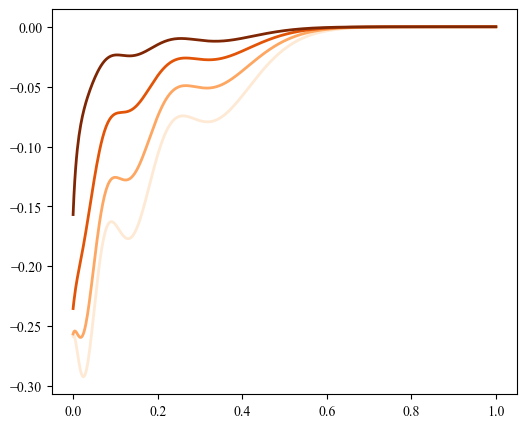

In [308]:
# 创建图形
plt.figure(figsize=(6, 5))

# 生成 x 轴数据
x_data = np.linspace(0, 1, len(v_01))

# 使用颜色渐变
colors = plt.cm.Oranges(np.linspace(0.1, 1, 4))

# 绘制五条曲线
plt.plot(x_data, v_ab18_04, color=colors[0], label="800",linewidth = 2)
plt.plot(x_data, v_ab18_02, color=colors[1], label="400",linewidth = 2)
plt.plot(x_data, v_ab18_01, color=colors[2], label="200",linewidth = 2)
plt.plot(x_data, v_ab18_005, color=colors[3], label="100",linewidth = 2)

In [320]:
# ab=12:
#v_ab12_04 = kymo_v[90]
#v_ab12_02 = kymo_v[90]
#v_ab12_01 = kymo_v[90]
#v_ab12_005 = kymo_v[90]
v_ab12_005[100]

-0.014654799405285829

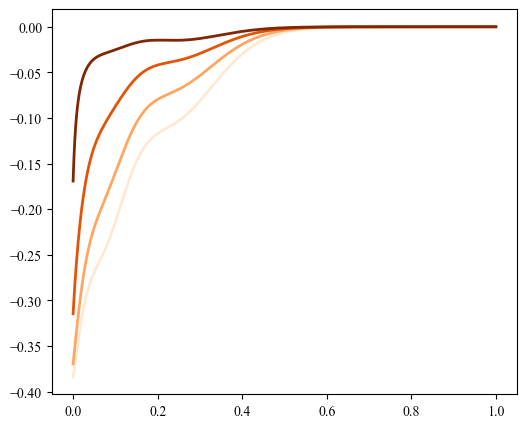

In [309]:
# 创建图形
plt.figure(figsize=(6, 5))

# 生成 x 轴数据
x_data = np.linspace(0, 1, len(v_01))

# 使用颜色渐变
colors = plt.cm.Oranges(np.linspace(0.1, 1, 4))

# 绘制五条曲线
plt.plot(x_data, v_ab12_04, color=colors[0], label="800",linewidth = 2)
plt.plot(x_data, v_ab12_02, color=colors[1], label="400",linewidth = 2)
plt.plot(x_data, v_ab12_01, color=colors[2], label="200",linewidth = 2)
plt.plot(x_data, v_ab12_005, color=colors[3], label="100",linewidth = 2)

In [332]:
# ab=6:
#v_ab6_04 = kymo_v[90]
#v_ab6_02 = kymo_v[90]
#v_ab6_01 = kymo_v[90]
#v_ab6_005 = kymo_v[90]
v_ab6_04[100]

-0.11713638153159744

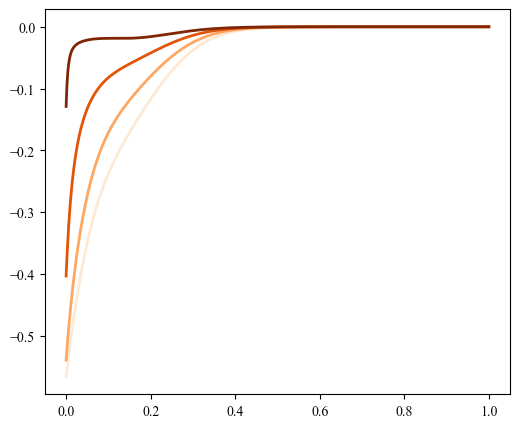

In [310]:
# 创建图形
plt.figure(figsize=(6, 5))

# 生成 x 轴数据
x_data = np.linspace(0, 1, len(v_01))

# 使用颜色渐变
colors = plt.cm.Oranges(np.linspace(0.1, 1, 4))

# 绘制五条曲线
plt.plot(x_data, v_ab6_04, color=colors[0], label="800",linewidth = 2)
plt.plot(x_data, v_ab6_02, color=colors[1], label="400",linewidth = 2)
plt.plot(x_data, v_ab6_01, color=colors[2], label="200",linewidth = 2)
plt.plot(x_data, v_ab6_005, color=colors[3], label="100",linewidth = 2)

In [165]:
# 设置默认字体为 Times New Roman
plt.rc('font', family='Times New Roman')

#v_05 = kymo_v[90]
#v_02 = kymo_v[90]
#v_01 = kymo_v[90]
#v_005 = kymo_v[90]
#v_001 = kymo_v[90]

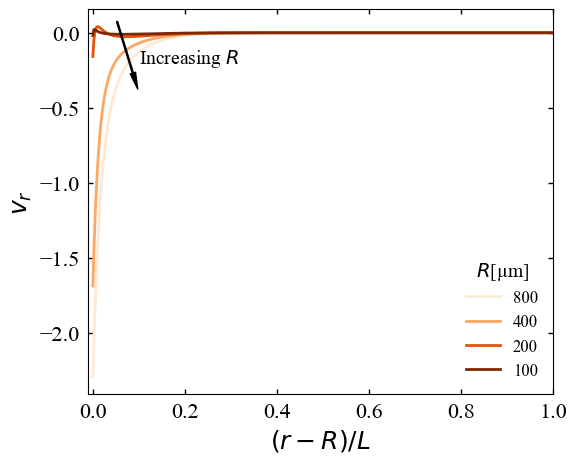

In [363]:
# 创建图形
plt.figure(figsize=(6, 5))

# 生成 x 轴数据
x_data = np.linspace(0, 1, len(v_01))

# 使用颜色渐变
colors = plt.cm.Oranges(np.linspace(0.1, 1, 4))

# 绘制五条曲线
plt.plot(x_data, v_05, color=colors[0], label="800",linewidth = 2)
plt.plot(x_data, v_02, color=colors[1], label="400",linewidth = 2)
plt.plot(x_data, v_01, color=colors[2], label="200",linewidth = 2)
plt.plot(x_data, v_005, color=colors[3], label="100",linewidth = 2)



# 调整图形
plt.xlim(-0.01, 0.2)
# plt.ylim(0, 0.4)
plt.yticks([0,-0.5, -1,-1.5,-2.0], fontsize=16)
plt.xticks([0, 0.2,0.4,0.6,0.8,1.0], fontsize=16)

plt.text(0.1, -0.2, r'Increasing $R$', fontsize=14)
plt.annotate('', xy=(0.1, -0.4), xytext=(0.05, 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05, width=0.8, headwidth=4))

plt.xlabel(r'$(r-R)/L$',fontsize=18)
plt.ylabel(r'$v_r$',fontsize=18)


# 调整横纵坐标标度线向内，并设置刻度线的粗细，同时隐藏标度值
plt.tick_params(axis='y', direction='in', width=1, right = True,labelleft=True, labelright=False)  # 只显示左右y轴刻度线，隐藏标签
plt.tick_params(axis='x', direction='in', width=1, top = True, labelbottom=True, labeltop=False)  # 只显示上下x轴刻度线，隐藏标签

# # # 隐藏 0 对应的刻度线
# ax = plt.gca()
# ax.get_yticklines()[0].set_visible(False)  # 隐藏第一个刻度线，通常对应于0
# ax.get_yticklines()[8].set_visible(False)  # 隐藏第一个刻度线，通常对应于0
# ax.get_xticklines()[0].set_visible(False)  # 隐藏第一个刻度线，通常对应于0

plt.gca().tick_params(axis='y', which='major', pad=6)
plt.gca().tick_params(axis='x', which='major', pad=6)  # Adjust the padding of x-axis labels

# # 自定义图例
# custom_lines = [
#     Line2D([0], [0], color='black', lw=2, linestyle='-'),
#     Line2D([0], [0], color='black', lw=2, linestyle='--')
# ]

# # 显示图例，并去掉背景框
# plt.legend(custom_lines, ['Simulation', 'Theory'], loc='upper left', fontsize=12, frameon=False)
# Custom legend to match the desired format
plt.legend(title=r'$R$[µm]', loc='lower right', fontsize=12, title_fontsize=14, frameon=False)
# 导出为矢量图格式，比如PDF、SVG或EPS
plt.savefig("f6.svg", format="eps")  # 可以将"svg"替换为"pdf"或"eps"等格式
# 显示图形
plt.show()

In [339]:
v_005[100]

-0.0023019801576091726

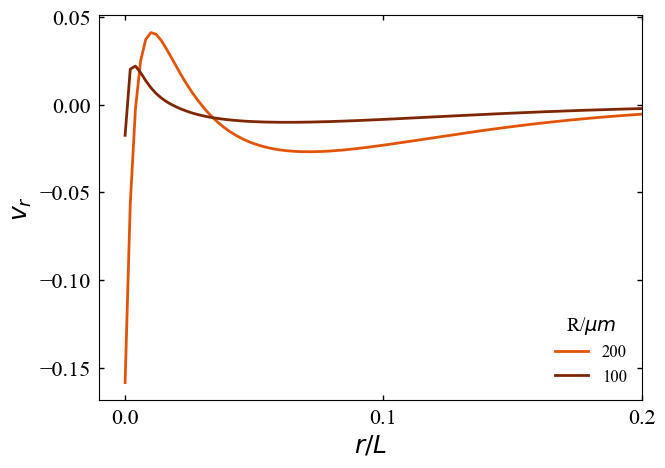

In [183]:
# 创建图形
plt.figure(figsize=(7, 5))

# 生成 x 轴数据
x_data = np.linspace(0, 1, len(v_01))

# 使用颜色渐变
# colors = plt.cm.Blues(np.linspace(0.4, 1, 4))

# 绘制五条曲线
# plt.plot(x_data, v_05, color=colors[0], label="800")
# plt.plot(x_data, v_02, color=colors[1], label="400")
plt.plot(x_data, v_01, color=colors[2], label="200",linewidth = 2)
plt.plot(x_data, v_005, color=colors[3], label="100",linewidth = 2)



# 调整图形
plt.xlim(-0.01, 0.2)
# plt.ylim(0, 0.4)
plt.yticks([0.05,0, -0.05,-0.1,-0.15], fontsize=16)
plt.xticks([0, 0.1,0.2], fontsize=16)

# plt.text(0.95, 0.26, r'Increasing $p_0$', fontsize=14)
# plt.annotate('', xy=(0.7, 0.05), xytext=(1, 0.35),
#              arrowprops=dict(facecolor='black', shrink=0.05, width=0.8, headwidth=4))

plt.xlabel(r'$r/L$',fontsize=18)
plt.ylabel(r'$v_r$',fontsize=18)


# 调整横纵坐标标度线向内，并设置刻度线的粗细，同时隐藏标度值
plt.tick_params(axis='y', direction='in', width=1, right = True,labelleft=True, labelright=False)  # 只显示左右y轴刻度线，隐藏标签
plt.tick_params(axis='x', direction='in', width=1, top = True, labelbottom=True, labeltop=False)  # 只显示上下x轴刻度线，隐藏标签

# # # 隐藏 0 对应的刻度线
# ax = plt.gca()
# ax.get_yticklines()[0].set_visible(False)  # 隐藏第一个刻度线，通常对应于0
# ax.get_yticklines()[8].set_visible(False)  # 隐藏第一个刻度线，通常对应于0
# ax.get_xticklines()[0].set_visible(False)  # 隐藏第一个刻度线，通常对应于0

plt.gca().tick_params(axis='y', which='major', pad=6)
plt.gca().tick_params(axis='x', which='major', pad=6)  # Adjust the padding of x-axis labels

# # 自定义图例
# custom_lines = [
#     Line2D([0], [0], color='black', lw=2, linestyle='-'),
#     Line2D([0], [0], color='black', lw=2, linestyle='--')
# ]

# # 显示图例，并去掉背景框
# plt.legend(custom_lines, ['Simulation', 'Theory'], loc='upper left', fontsize=12, frameon=False)
# Custom legend to match the desired format
plt.legend(title=r'R/$\mu m$', loc='lower right', fontsize=12, title_fontsize=14, frameon=False)
# 导出为矢量图格式，比如PDF、SVG或EPS
plt.savefig("f6_1.svg", format="eps")  # 可以将"svg"替换为"pdf"或"eps"等格式
# 显示图形
plt.show()

In [83]:
# For mehano-chemo coupling with ab =24:
# v2_04 = kymo_v[90]
# e2_04 = kymo_E[90]
# v2_02 = kymo_v[90]
# e2_02 = kymo_E[90]
# v2_01 = kymo_v[90]
# e2_01 = kymo_E[90]
# v2_005 = kymo_v[90]
# e2_005 = kymo_E[90]

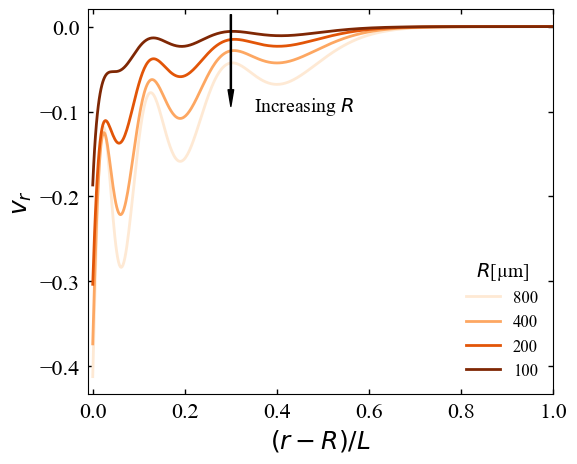

In [364]:
# 创建图形
plt.figure(figsize=(6, 5))

# 生成 x 轴数据
x_data = np.linspace(0, 1, len(v2_02))

# 使用颜色渐变
# colors = plt.cm.Blues(np.linspace(0.4, 1, 4))

# 绘制五条曲线

plt.plot(x_data, v2_04, color=colors[0], label="800",linewidth = 2)
plt.plot(x_data, v2_02, color=colors[1], label="400",linewidth = 2)
plt.plot(x_data, v2_01, color=colors[2], label="200",linewidth = 2)
plt.plot(x_data, v2_005, color=colors[3], label="100",linewidth = 2)


# 调整图形
plt.xlim(-0.01, 1)
# plt.ylim(0, 0.4)
plt.yticks([0, -0.1,-0.2,-0.3,-0.4], fontsize=16)
plt.xticks([0, 0.2,0.4,0.6,0.8,1.0], fontsize=16)

plt.text(0.35, -0.1, r'Increasing $R$', fontsize=14)
plt.annotate('', xy=(0.3, -0.1), xytext=(0.3, 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05, width=0.8, headwidth=4))

plt.xlabel(r'$(r-R)/L$',fontsize=18)
plt.ylabel(r'$v_r$',fontsize=18)


# 调整横纵坐标标度线向内，并设置刻度线的粗细，同时隐藏标度值
plt.tick_params(axis='y', direction='in', width=1, right = True,labelleft=True, labelright=False)  # 只显示左右y轴刻度线，隐藏标签
plt.tick_params(axis='x', direction='in', width=1, top = True, labelbottom=True, labeltop=False)  # 只显示上下x轴刻度线，隐藏标签

# # # 隐藏 0 对应的刻度线
# ax = plt.gca()
# ax.get_yticklines()[0].set_visible(False)  # 隐藏第一个刻度线，通常对应于0
# ax.get_yticklines()[8].set_visible(False)  # 隐藏第一个刻度线，通常对应于0
# ax.get_xticklines()[0].set_visible(False)  # 隐藏第一个刻度线，通常对应于0

plt.gca().tick_params(axis='y', which='major', pad=6)
plt.gca().tick_params(axis='x', which='major', pad=6)  # Adjust the padding of x-axis labels

# # 自定义图例
# custom_lines = [
#     Line2D([0], [0], color='black', lw=2, linestyle='-'),
#     Line2D([0], [0], color='black', lw=2, linestyle='--')
# ]

# # 显示图例，并去掉背景框
# plt.legend(custom_lines, ['Simulation', 'Theory'], loc='upper left', fontsize=12, frameon=False)
# Custom legend to match the desired format
plt.legend(title=r'$R$[µm]', loc='lower right', fontsize=12, title_fontsize=14, frameon=False)
# 导出为矢量图格式，比如PDF、SVG或EPS
plt.savefig("f6_2.svg", format="eps")  # 可以将"svg"替换为"pdf"或"eps"等格式
# 显示图形
plt.show()

In [336]:
v2_005[100]

-0.023064961962117575

In [99]:
# R =0.1 with various ab: 0,6,12,18,24
# v3_6 = kymo_v[90]
# e3_6 = kymo_E[90]
# v3_12 = kymo_v[90]
# e3_12 = kymo_E[90]
v3_18 = kymo_v[90]
e3_18 = kymo_E[90]

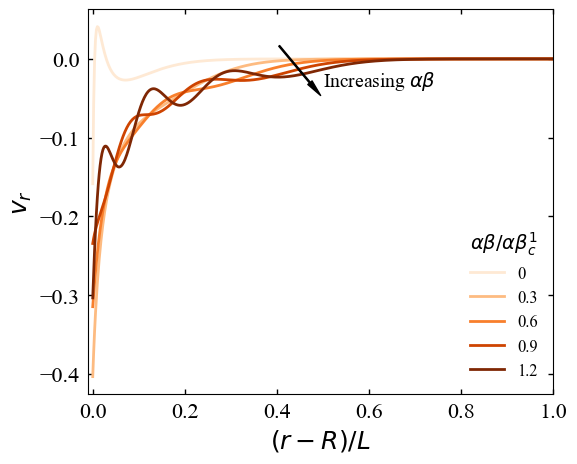

In [360]:
# 创建图形
plt.figure(figsize=(6, 5))

# 生成 x 轴数据
x_data = np.linspace(0, 1, len(v2_02))

# 使用颜色渐变
colors = plt.cm.Oranges(np.linspace(0.1, 1, 5))

# 绘制五条曲线

plt.plot(x_data, v_01, color=colors[0], label="0",linewidth = 2)
plt.plot(x_data, v3_6, color=colors[1], label="0.3",linewidth = 2)
plt.plot(x_data, v3_12, color=colors[2], label="0.6",linewidth = 2)
plt.plot(x_data, v3_18, color=colors[3], label="0.9",linewidth = 2)
plt.plot(x_data, v2_01, color=colors[4], label="1.2",linewidth = 2)


# 调整图形
plt.xlim(-0.01, 1)
#plt.ylim(-0.4, 0.05)
plt.yticks([0, -0.1,-0.2,-0.3,-0.4], fontsize=16)
plt.xticks([0, 0.2,0.4,0.6,0.8,1.0], fontsize=16)

plt.text(0.5, -0.035, r'Increasing $\alpha\beta$', fontsize=14)
plt.annotate('', xy=(0.5, -0.05), xytext=(0.4, 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05, width=0.8, headwidth=4))

plt.xlabel(r'$(r-R)/L$',fontsize=18)
plt.ylabel(r'$v_r$',fontsize=18)


# 调整横纵坐标标度线向内，并设置刻度线的粗细，同时隐藏标度值
plt.tick_params(axis='y', direction='in', width=1, right = True,labelleft=True, labelright=False)  # 只显示左右y轴刻度线，隐藏标签
plt.tick_params(axis='x', direction='in', width=1, top = True, labelbottom=True, labeltop=False)  # 只显示上下x轴刻度线，隐藏标签

# # # 隐藏 0 对应的刻度线
# ax = plt.gca()
# ax.get_yticklines()[0].set_visible(False)  # 隐藏第一个刻度线，通常对应于0
# ax.get_yticklines()[8].set_visible(False)  # 隐藏第一个刻度线，通常对应于0
# ax.get_xticklines()[0].set_visible(False)  # 隐藏第一个刻度线，通常对应于0

plt.gca().tick_params(axis='y', which='major', pad=6)
plt.gca().tick_params(axis='x', which='major', pad=6)  # Adjust the padding of x-axis labels

# # 自定义图例
# custom_lines = [
#     Line2D([0], [0], color='black', lw=2, linestyle='-'),
#     Line2D([0], [0], color='black', lw=2, linestyle='--')
# ]

# # 显示图例，并去掉背景框
# plt.legend(custom_lines, ['Simulation', 'Theory'], loc='upper left', fontsize=12, frameon=False)
# Custom legend to match the desired format
plt.legend(title=r'$\alpha\beta/\alpha\beta_c^1$', loc='lower right', fontsize=12, title_fontsize=14, frameon=False)
# 导出为矢量图格式，比如PDF、SVG或EPS
plt.savefig("f6_3.svg", format="eps")  # 可以将"svg"替换为"pdf"或"eps"等格式
# 显示图形
plt.show()

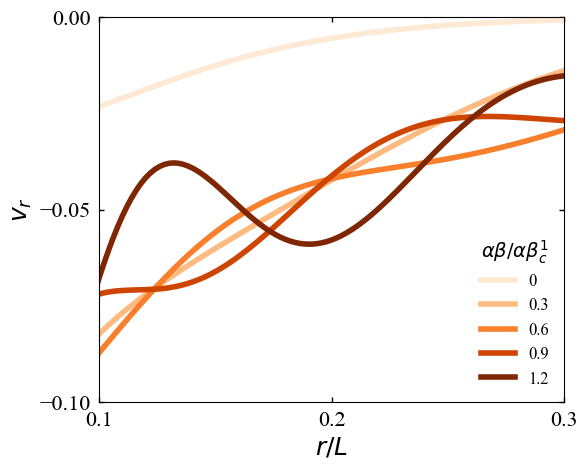

In [359]:
# 创建图形
plt.figure(figsize=(6, 5))

# 生成 x 轴数据
x_data = np.linspace(0, 1, len(v2_02))

# 使用颜色渐变
colors = plt.cm.Oranges(np.linspace(0.1, 1, 5))

# 绘制五条曲线

plt.plot(x_data, v_01, color=colors[0], label="0",linewidth = 4)
plt.plot(x_data, v3_6, color=colors[1], label="0.3",linewidth = 4)
plt.plot(x_data, v3_12, color=colors[2], label="0.6",linewidth = 4)
plt.plot(x_data, v3_18, color=colors[3], label="0.9",linewidth = 4)
plt.plot(x_data, v2_01, color=colors[4], label="1.2",linewidth = 4)


# 调整图形
plt.xlim(0.1, 0.3)
plt.ylim(-0.1, 0)
plt.yticks([0, -0.05,-0.1], fontsize=16)
plt.xticks([0.1,0.2,0.3], fontsize=16)

# plt.text(0.5, -0.035, r'Increasing $\alpha\beta$', fontsize=14)
# plt.annotate('', xy=(0.5, -0.05), xytext=(0.4, 0.02),
#              arrowprops=dict(facecolor='black', shrink=0.05, width=0.8, headwidth=4))

plt.xlabel(r'$r/L$',fontsize=18)
plt.ylabel(r'$v_r$',fontsize=18)


# 调整横纵坐标标度线向内，并设置刻度线的粗细，同时隐藏标度值
plt.tick_params(axis='y', direction='in', width=1, right = True,labelleft=True, labelright=False)  # 只显示左右y轴刻度线，隐藏标签
plt.tick_params(axis='x', direction='in', width=1, top = True, labelbottom=True, labeltop=False)  # 只显示上下x轴刻度线，隐藏标签

# # # 隐藏 0 对应的刻度线
# ax = plt.gca()
# ax.get_yticklines()[0].set_visible(False)  # 隐藏第一个刻度线，通常对应于0
# ax.get_yticklines()[8].set_visible(False)  # 隐藏第一个刻度线，通常对应于0
# ax.get_xticklines()[0].set_visible(False)  # 隐藏第一个刻度线，通常对应于0

plt.gca().tick_params(axis='y', which='major', pad=6)
plt.gca().tick_params(axis='x', which='major', pad=6)  # Adjust the padding of x-axis labels

# # 自定义图例
# custom_lines = [
#     Line2D([0], [0], color='black', lw=2, linestyle='-'),
#     Line2D([0], [0], color='black', lw=2, linestyle='--')
# ]

# # 显示图例，并去掉背景框
# plt.legend(custom_lines, ['Simulation', 'Theory'], loc='upper left', fontsize=12, frameon=False)
# Custom legend to match the desired format
plt.legend(title=r'$\alpha\beta/\alpha\beta_c^1$', loc='lower right', fontsize=12, title_fontsize=14, frameon=False)
# 导出为矢量图格式，比如PDF、SVG或EPS
plt.savefig("f6_3_2.svg", format="eps")  # 可以将"svg"替换为"pdf"或"eps"等格式
# 显示图形
plt.show()

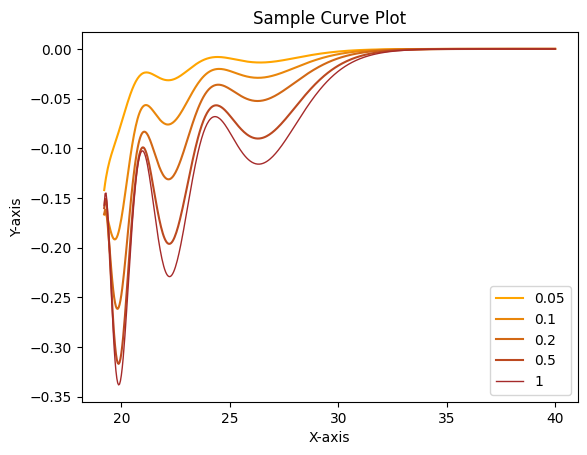

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
# 自定义从橙色到褐色的渐变色图
colors = ["orange", "brown"]
n_bins = 5  # 使用5个颜色级别
cmap_name = 'orange_brown'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# 创建一个新的图形
plt.figure()
x = np.linspace(RS*L_values[0],RE* L_values[0], Nx + 1)
y3_1 = kymo_v[80]
e3_1 = kymo_E[80]
#marker='o'
# 绘制曲线图
plt.plot(x, y4_1,color=cm(0),label='0.05')
plt.plot(x, y5_1,color=cm(1),label='0.1')
plt.plot(x, y1_1,color=cm(2),label='0.2')
plt.plot(x, y2_1,color=cm(3),label='0.5')
plt.plot(x, y3_1,color=cm(4),linewidth=1,label='1')

# 添加标题和标签
plt.title('Sample Curve Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# 显示图例
plt.legend()

# 显示图表
plt.show()

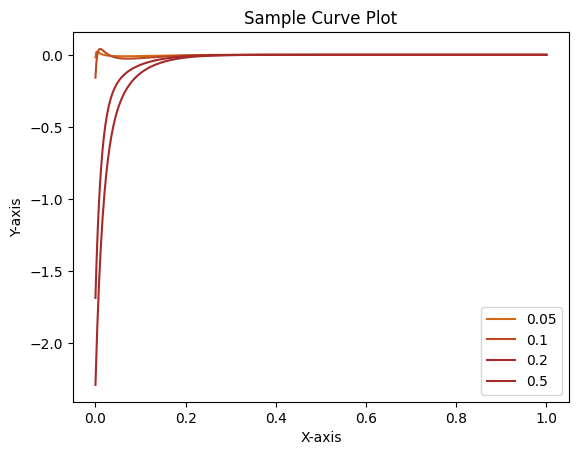

In [37]:
from matplotlib.colors import LinearSegmentedColormap
# 自定义从橙色到褐色的渐变色图
colors = ["orange", "brown"]
n_bins = 5  # 使用5个颜色级别
cmap_name = 'orange_brown'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# 创建一个新的图形
plt.figure()
# x = np.linspace(RS*L_values[0],RE* L_values[0], Nx + 1)
x = np.linspace(0,1, Nx + 1)
y1 = kymo_v[90]
#e4_1 = kymo_E[80]
#marker='o'
# 绘制曲线图
# plt.plot(x, v_001,color=cm(0),label='0.01')
plt.plot(x, v_005,color=cm(2),label='0.05')
plt.plot(x, v_01,color=cm(3),label='0.1')
plt.plot(x, v_02,color=cm(4),label='0.2')
plt.plot(x, v_05,color=cm(4),label='0.5')

# plt.plot(x, y5,color=cm(1),label='0.1')
# plt.plot(x, y1,color=cm(2),label='0.2')
# plt.plot(x, y2,color=cm(3),label='0.5')
# plt.plot(x, y3,color=cm(4),linewidth=1,label='1')

# 添加标题和标签
plt.title('Sample Curve Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# 显示图例
plt.legend()

# 显示图表
plt.show()

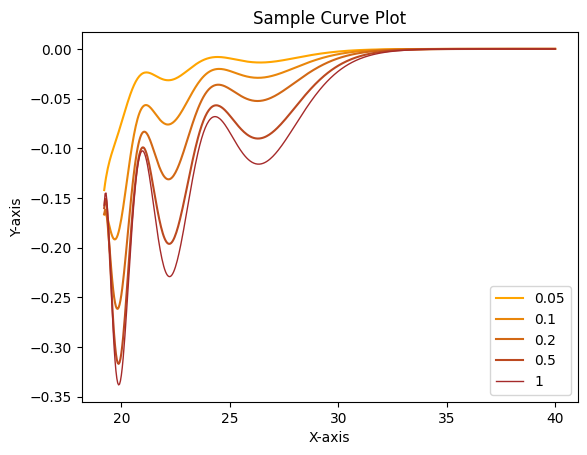

In [136]:
from matplotlib.colors import LinearSegmentedColormap
# 自定义从橙色到褐色的渐变色图
colors = ["orange", "brown"]
n_bins = 5  # 使用5个颜色级别
cmap_name = 'orange_brown'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# 创建一个新的图形
plt.figure()
x = np.linspace(RS*L_values[0],RE* L_values[0], Nx + 1)
y3_1 = kymo_v[80]
e3_1 = kymo_E[80]
#marker='o'
# 绘制曲线图
plt.plot(x, y4_1,color=cm(0),label='0.05')
plt.plot(x, y5_1,color=cm(1),label='0.1')
plt.plot(x, y1_1,color=cm(2),label='0.2')
plt.plot(x, y2_1,color=cm(3),label='0.5')
plt.plot(x, y3_1,color=cm(4),linewidth=1,label='1')

# 添加标题和标签
plt.title('Sample Curve Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# 显示图例
plt.legend()

# 显示图表
plt.show()

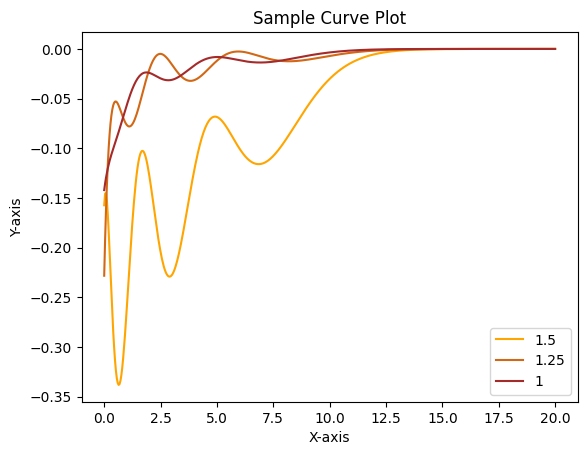

In [135]:
# Find out the effects of mechano_chemical coupling
# 创建一个新的图形
plt.figure()
x = np.linspace(0,20, Nx + 1)
y4_15 = kymo_v[80]
e4_15 = kymo_E[80]
#marker='o'
# 绘制曲线图
plt.plot(x, y4_15, color=cm(0), label='1.5')
plt.plot(x, y4_125, color=cm(2), label='1.25')
plt.plot(x, y4_1,color=cm(4), label='1')
# plt.plot(x, y4_075, color=cm(1), label='0.75')
# plt.plot(x, y4_05, color=cm(2), label='0.5')
# plt.plot(x, y4_025, color=cm(3), label='0.25')
# plt.plot(x, y4,  color=cm(4), label='0.5_0')
# plt.plot(x, y1, label='0.2')
# plt.plot(x, y2, label='0.5')
# plt.plot(x, y3, linewidth=1,label='1')

# 添加标题和标签
plt.title('Sample Curve Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# 显示图例
plt.legend()

# 显示图表
plt.show()

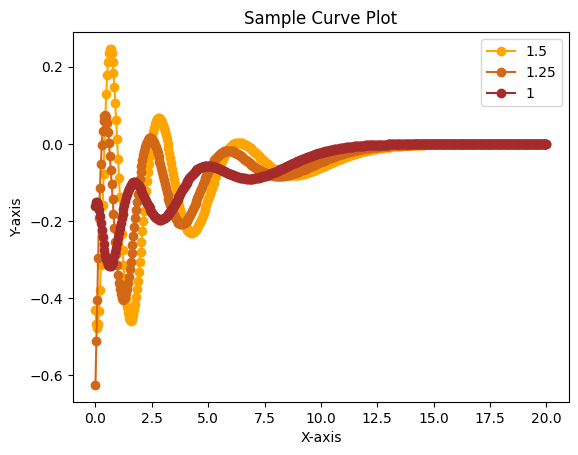

In [99]:
# Find out the effects of mechano_chemical coupling
# 创建一个新的图形
plt.figure()
x = np.linspace(0,20, Nx + 1)
y2_125 = kymo_v[80]
e2_125 = kymo_E[80]
#marker='o'
# 绘制曲线图
plt.plot(x, y2_15, marker='o',color=cm(0), label='1.5')
plt.plot(x, y2_125, marker='o',color=cm(2), label='1.25')
plt.plot(x, y2_1, marker='o',color=cm(4), label='1')
#plt.plot(x, y2_075, color=cm(1), label='0.75')
#plt.plot(x, y2_05, color=cm(2), label='0.5')
#plt.plot(x, y2_025, color=cm(3), label='0.25')
#plt.plot(x, y2,  color=cm(4), label='0.5_0')
# plt.plot(x, y1, label='0.2')
# plt.plot(x, y2, label='0.5')
# plt.plot(x, y3, linewidth=1,label='1')

# 添加标题和标签
plt.title('Sample Curve Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# 显示图例
plt.legend()

# 显示图表
plt.show()

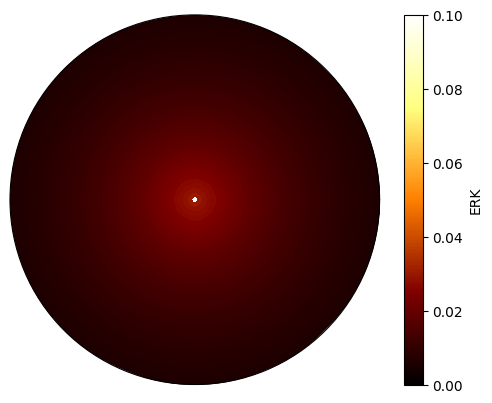

In [6]:

## Profiles in circular geometry
from matplotlib.colors import LinearSegmentedColormap
# Time and length
n = 4
length = 40  

# Expanding one-dimensional data to two dimensions
radius = np.linspace(0, 0.4, length)       # Radius range
theta = np.linspace(0, np.pi*2, length)    # Angular range, representing a full circle
R, Theta = np.meshgrid(radius, theta)      # Create grid
EE = np.tile(kymo_E[n][:40], (length, 1))  # Duplicate data to two dimensions

# Plotting in polar coordinates
fig, ax = plt.subplots(subplot_kw={'polar': True})
colors = ["blue", "green", "yellow", "red"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
c = ax.pcolormesh(Theta, R, EE, shading='auto', cmap='afmhot', vmin=0, vmax=0.1)  # Plot concentration data

# Set polar coordinates parameters to only display a full circle
ax.set_ylim(0,0.4) # Set radius range
ax.set_yticks([])  # Hide radial ticks
ax.set_xticks([])  # Hide angular ticks
ax.set_thetamin(0)  # Set the minimum angle
ax.set_thetamax(360)  # Set the maximum angle

# Add a color bar
plt.colorbar(c, ax=ax, label='ERK')

# Display the plot
plt.show()


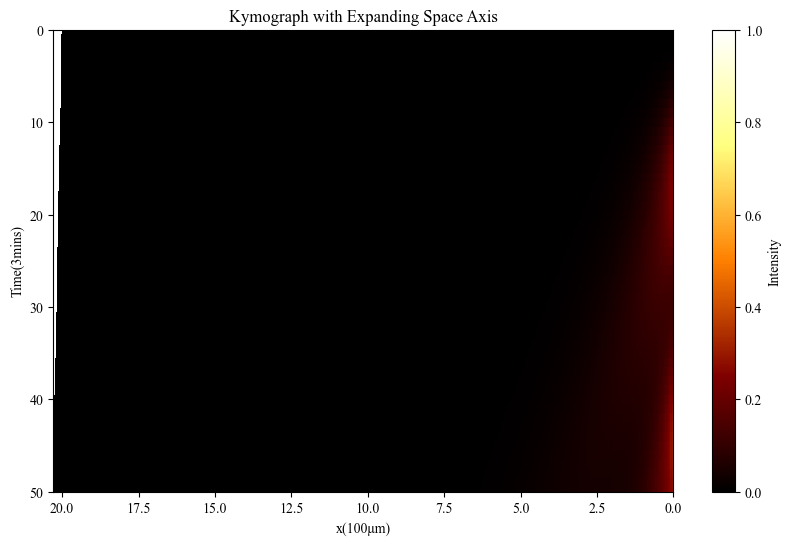

In [248]:
### Plot kymograph

# Current time step
N = 50
# Initialize the figure and axis for the kymograph
fig, ax = plt.subplots(figsize=(10, 6))

# We will plot the kymograph as a collection of patches, one for each time step
for i in range(N):
    # Calculate the extent of the space axis for the current time step
    current_extent = L_values[2*i]
    # Calculate the x-axis values for the current time step
    x_values = np.linspace(0, current_extent, 501)
    # Select the appropriate row from the data array for the current time step
    row_data = kymo_E[i]
    # Define the y-axis range for the current time step
    y_values = [i,i+1]
    # Create a meshgrid for the x and y values
    X, Y = np.meshgrid(x_values, y_values)
    # Plot the data for the current time step as a patch
    quadmesh = ax.pcolormesh(X, Y, np.vstack([row_data, row_data]), shading='auto', cmap='afmhot',vmin=0,vmax=1)

# Set the labels and title of the kymograph
ax.set_xlabel('x(100μm)')
ax.set_ylabel('Time(3mins)')
ax.set_title('Kymograph with Expanding Space Axis')

# Adjust the limits of the y-axis to ensure all data is visible
ax.set_ylim(N, 0)
ax.set_xlim(current_extent, 0)

cbar = fig.colorbar(quadmesh, ax=ax)
cbar.set_label('Intensity')

# Show the plot
plt.show()

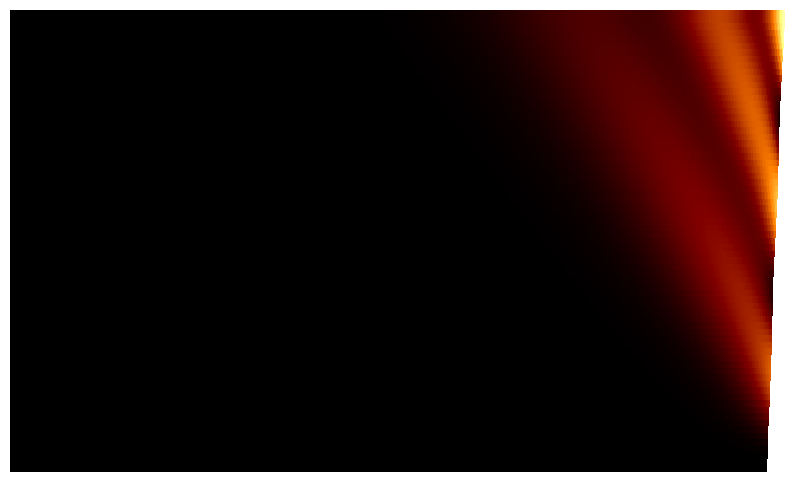

In [264]:
# Initialize the figure and axis for the kymograph
fig, ax = plt.subplots(figsize=(10, 6))
# Current time step
N = 70
# We will plot the kymograph as a collection of patches, one for each time step
for i in range(N):
    # Calculate the extent of the space axis for the current time step
    current_extent = L_values[2*i]
    # Calculate the x-axis values for the current time step
    x_values = np.linspace( current_extent,0, 501)
    # Select the appropriate row from the data array for the current time step
    row_data = kymo_E[i]
    # Define the y-axis range for the current time step
    y_values = [i, i+1]
    # Create a meshgrid for the x and y values
    X, Y = np.meshgrid(x_values, y_values)
    # Plot the data for the current time step as a patch
    quadmesh = ax.pcolormesh(X, Y, np.vstack([row_data, row_data]), shading='auto', cmap='afmhot', vmin=0, vmax=0.7)

# Remove all the axes, ticks, and labels
ax.axis('off')
plt.savefig("f5_1_2.svg", format="eps")  # 可以将"svg"替换为"pdf"或"eps"等格式
# Show the plot without any borders or labels
plt.show()

In [265]:
v=np.diff(kymo_v)

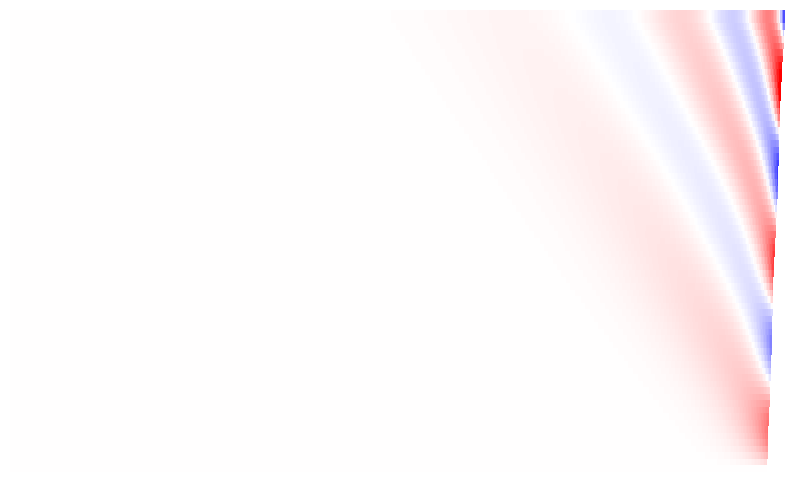

In [266]:
# Initialize the figure and axis for the kymograph
fig, ax = plt.subplots(figsize=(10, 6))
# Current time step
N = 70
# We will plot the kymograph as a collection of patches, one for each time step
for i in range(N):
    # Calculate the extent of the space axis for the current time step
    current_extent = L_values[2*i]
    # Calculate the x-axis values for the current time step
    x_values = np.linspace(current_extent,0, 500)
    # Select the appropriate row from the data array for the current time step
    row_data = v[i]
    # Define the y-axis range for the current time step
    y_values = [i, i+1]
    # Create a meshgrid for the x and y values
    X, Y = np.meshgrid(x_values, y_values)
    # Plot the data for the current time step as a patch
    quadmesh = ax.pcolormesh(X, Y, np.vstack([row_data, row_data]), shading='auto', cmap='bwr', vmin=-0.03, vmax=0.03)

# Remove all the axes, ticks, and labels
ax.axis('off')
plt.savefig("f5_1_1.svg", format="eps")  # 可以将"svg"替换为"pdf"或"eps"等格式
# Show the plot without any borders or labels
plt.show()